/tmp/ipykernel_607/1610090845.py:136: RuntimeWarning: Mean of empty slice
  avg_r_half = np.nanmean(np.array(aligned_metrics['r_half']), axis=0)
/tmp/ipykernel_607/1610090845.py:137: RuntimeWarning: Mean of empty slice
  avg_first_neg = np.nanmean(np.array(aligned_metrics['first_neg']), axis=0)
/tmp/ipykernel_607/1610090845.py:138: RuntimeWarning: Mean of empty slice
  avg_second_pos = np.nanmean(np.array(aligned_metrics['second_pos']), axis=0)
/tmp/ipykernel_607/1610090845.py:142: RuntimeWarning: Mean of empty slice
  avg_orientation_cos = np.nanmean(np.array(aligned_metrics['orientation_cos']), axis=0)
/tmp/ipykernel_607/1610090845.py:143: RuntimeWarning: Mean of empty slice
  avg_orientation_sin = np.nanmean(np.array(aligned_metrics['orientation_sin']), axis=0)


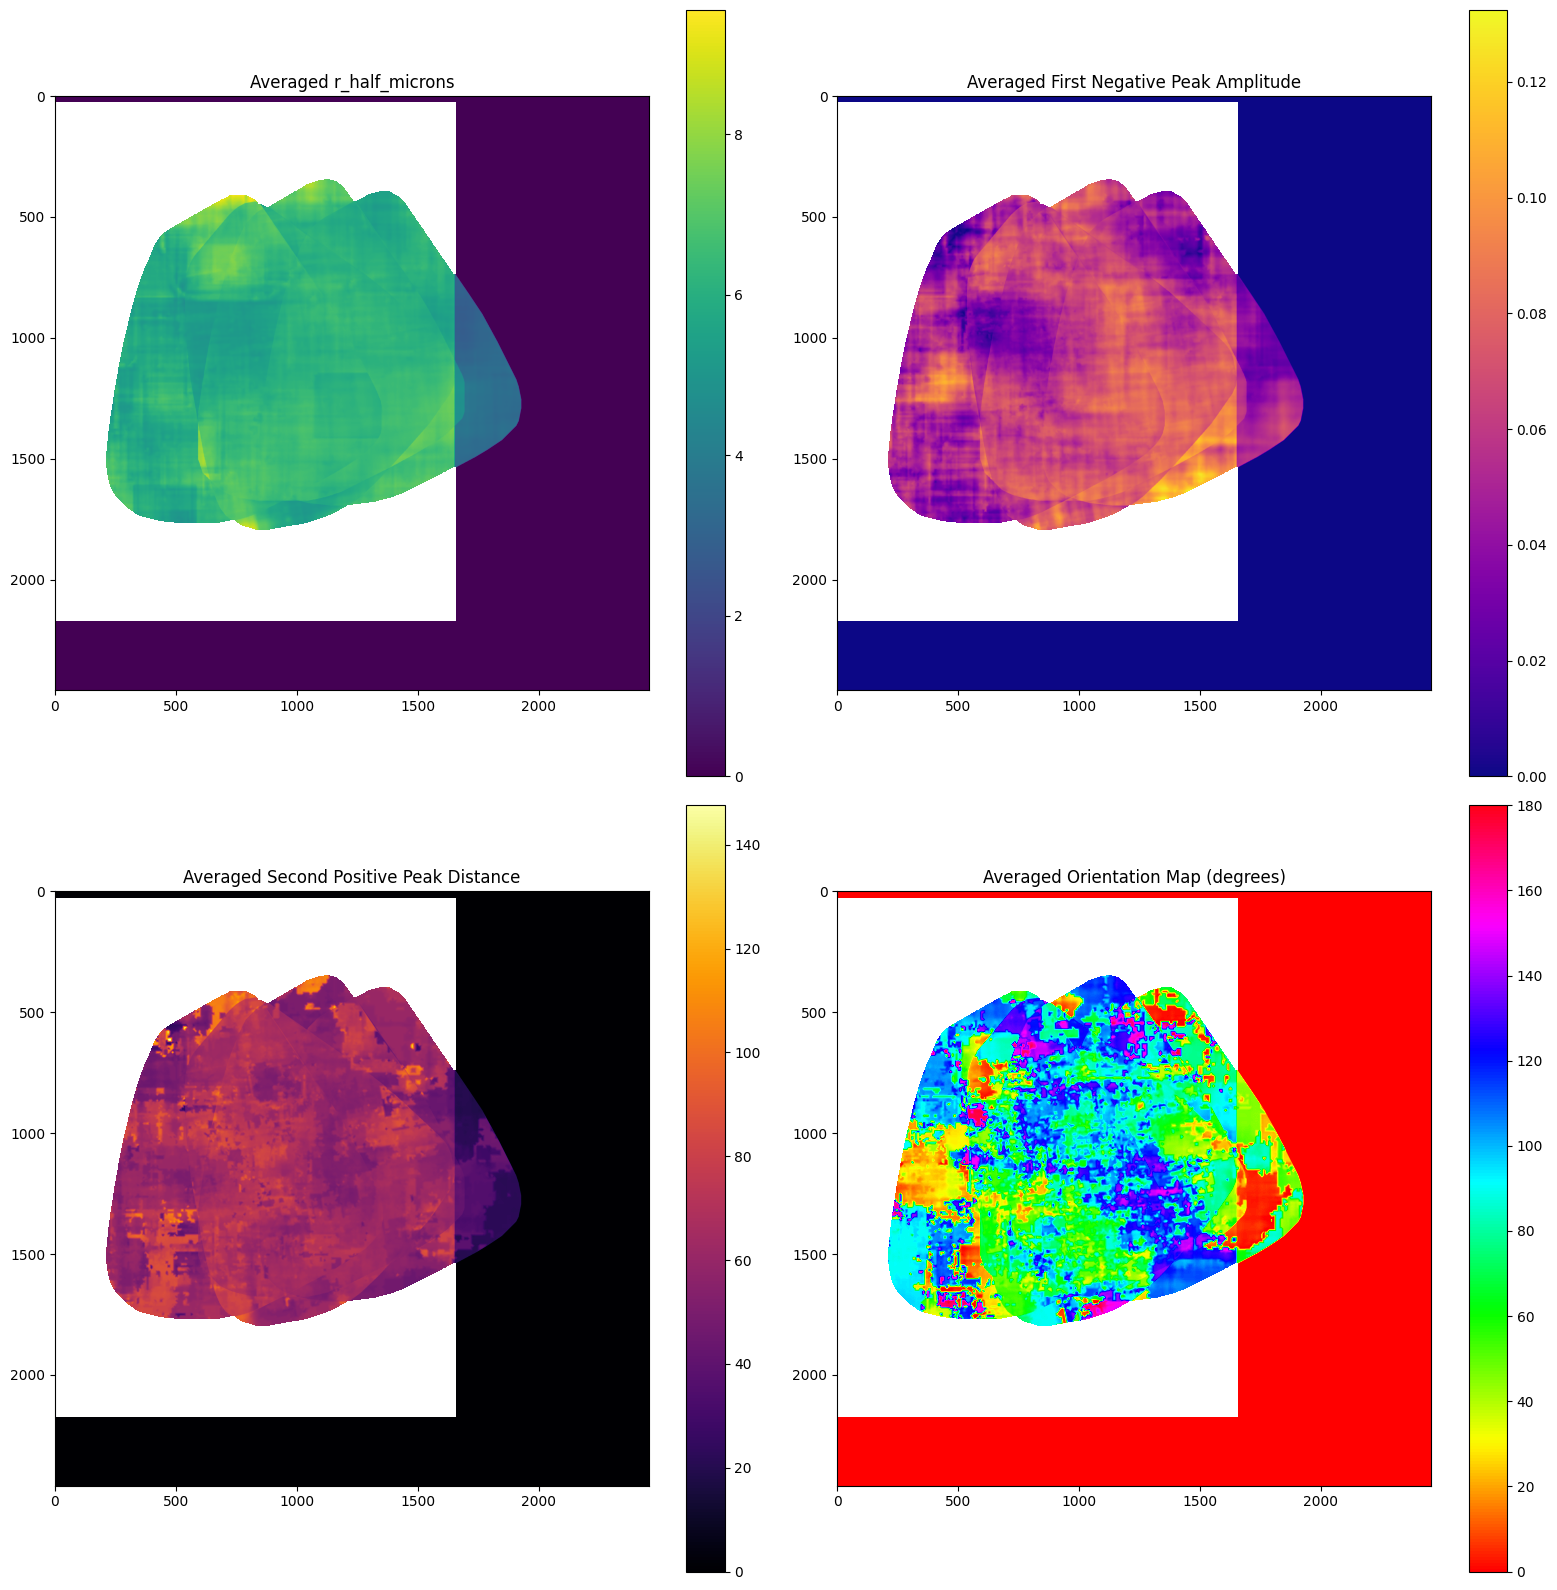

In [1]:
import numpy as np
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.measure import label, regionprops
from skimage.transform import SimilarityTransform, warp
from scipy.interpolate import griddata

# ---------------------------
# Parameters and Definitions
# ---------------------------
roi_size = 330  # must match the ROI size used when extracting metrics

def create_metric_images(csv_path, mask_path, roi_size):
    """
    Load the CSV file and generate full-field metric images by interpolating the ROI-based metrics.
    Assumes CSV columns: 'x', 'y', 'r_half_microns', 'first_negative_amp', 
    'second_positive_distance_microns', 'orientation_max_degrees'.
    
    The ROI center is computed as (x + roi_size/2, y + roi_size/2).
    """
    # Load CSV (assumes an index column if saved that way)
    df = pd.read_csv(csv_path, index_col=0)
    
    # Load mask to determine image dimensions (assumed to match the original image)
    mask_img = tifffile.imread(mask_path)
    img_shape = mask_img.shape
    
    # Create a grid for interpolation
    grid_y, grid_x = np.mgrid[0:img_shape[0], 0:img_shape[1]]
    
    # Compute ROI centers (in pixel coordinates)
    # Note: in the CSV, x and y indicate the top-left corner of each ROI.
    points = np.column_stack((df['y'] + roi_size/2, df['x'] + roi_size/2))
    
    # Interpolate each metric onto the full image grid.
    grid_r_half = griddata(points, df['r_half_microns'], (grid_y, grid_x),
                           method='linear', fill_value=np.nan)
    # For first negative peak amplitude, we convert to a positive value (for visualization)
    grid_first_neg = griddata(points, -df['first_negative_amp'], (grid_y, grid_x),
                              method='linear', fill_value=np.nan)
    grid_second_pos = griddata(points, df['second_positive_distance_microns'], (grid_y, grid_x),
                               method='linear', fill_value=np.nan)
    
    # For orientation, convert degrees to radians and adjust to [0, π)
    orientation_rad = np.deg2rad(df['orientation_max_degrees'] % 180)
    grid_orientation = griddata(points, orientation_rad, (grid_y, grid_x),
                                method='linear', fill_value=np.nan)
    
    return {
        'r_half': grid_r_half,
        'first_neg': grid_first_neg,
        'second_pos': grid_second_pos,
        'orientation': grid_orientation
    }

def register_image(metric_image, mask_image, template_props, template_shape):
    """
    Register (warp) the metric image so that the corresponding mask aligns with the template.
    The transformation is computed from the region properties (centroid, area, orientation).
    """
    current_label = label(mask_image)
    props = regionprops(current_label)[0]
    current_center = np.array(props.centroid)
    current_area = props.area
    current_orientation = props.orientation  # in radians
    
    # Estimate scale factor from area ratio (assuming similar shapes)
    scale_factor = np.sqrt(template_props.area / current_area)
    # Rotation difference between template and current mask
    rotation_diff = template_props.orientation - current_orientation
    # Translation to match centroids
    translation = np.array(template_props.centroid) - current_center
    
    # Build the similarity transform
    tform = SimilarityTransform(scale=scale_factor, rotation=rotation_diff, translation=translation)
    aligned_image = warp(metric_image, inverse_map=tform.inverse, output_shape=template_shape)
    return aligned_image

# -----------------------------------------------
# Choose a Template Mask for Registration
# -----------------------------------------------
# For example, we use Mask_99.tif as the template.
template_mask_file = Path("Mask_99.tif")
template_mask = tifffile.imread(template_mask_file) > 0.5
template_label = label(template_mask)
template_props = regionprops(template_label)[0]
template_shape = template_mask.shape

# -----------------------------------------------
# Process Each CSV and Corresponding Mask
# -----------------------------------------------
# List of sample base names. Adjust these to your naming convention.
base_names = ["LGN_99", "LGN_82", "LGN_80", "LGN_118"]

# Dictionaries to store registered metric images for each metric.
# For orientation, we store cosine and sine components separately for proper averaging.
aligned_metrics = {
    'r_half': [],
    'first_neg': [],
    'second_pos': [],
    'orientation_cos': [],
    'orientation_sin': []
}

for base in base_names:
    # Build paths: CSV file is in the "metrics_df" folder and mask is named like "Mask_XX.tif"
    csv_path = Path("metrics_df") / f"{base}.csv"
    # Here we assume the mask file uses the numeric suffix from the base name, e.g. "LGN_99" -> "Mask_99.tif"
    suffix = base.split('_')[-1]
    mask_path = Path(f"Mask_{suffix}.tif")
    
    # Create metric images from the CSV file.
    metrics = create_metric_images(csv_path, mask_path, roi_size)
    
    # Load the corresponding mask for registration.
    mask_img = tifffile.imread(mask_path) > 0.5
    
    # Register (warp) each metric image into the template coordinate system.
    aligned_r_half = register_image(metrics['r_half'], mask_img, template_props, template_shape)
    aligned_first_neg = register_image(metrics['first_neg'], mask_img, template_props, template_shape)
    aligned_second_pos = register_image(metrics['second_pos'], mask_img, template_props, template_shape)
    aligned_orientation = register_image(metrics['orientation'], mask_img, template_props, template_shape)
    
    aligned_metrics['r_half'].append(aligned_r_half)
    aligned_metrics['first_neg'].append(aligned_first_neg)
    aligned_metrics['second_pos'].append(aligned_second_pos)
    # For orientation, store the cosine and sine components for later averaging.
    aligned_metrics['orientation_cos'].append(np.cos(aligned_orientation))
    aligned_metrics['orientation_sin'].append(np.sin(aligned_orientation))

# ----------------------------------------------------
# Compute Pixel-Wise Averages for Each Metric
# ----------------------------------------------------
avg_r_half = np.nanmean(np.array(aligned_metrics['r_half']), axis=0)
avg_first_neg = np.nanmean(np.array(aligned_metrics['first_neg']), axis=0)
avg_second_pos = np.nanmean(np.array(aligned_metrics['second_pos']), axis=0)

# For orientation, average the cosine and sine components separately,
# then recover the angle.
avg_orientation_cos = np.nanmean(np.array(aligned_metrics['orientation_cos']), axis=0)
avg_orientation_sin = np.nanmean(np.array(aligned_metrics['orientation_sin']), axis=0)
avg_orientation = np.arctan2(avg_orientation_sin, avg_orientation_cos)
# Ensure orientation is in the range [0, π)
avg_orientation[avg_orientation < 0] += np.pi

# ----------------------------------------------------
# Visualization of the Averaged Metric Images
# ----------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs = axs.ravel()

im0 = axs[0].imshow(avg_r_half, cmap='viridis')
axs[0].set_title("Averaged r_half_microns")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(avg_first_neg, cmap='plasma')
axs[1].set_title("Averaged First Negative Peak Amplitude")
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(avg_second_pos, cmap='inferno')
axs[2].set_title("Averaged Second Positive Peak Distance")
fig.colorbar(im2, ax=axs[2])

# For orientation, display in degrees using a cyclic colormap.
im3 = axs[3].imshow(np.degrees(avg_orientation), cmap='hsv')
axs[3].set_title("Averaged Orientation Map (degrees)")
fig.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()


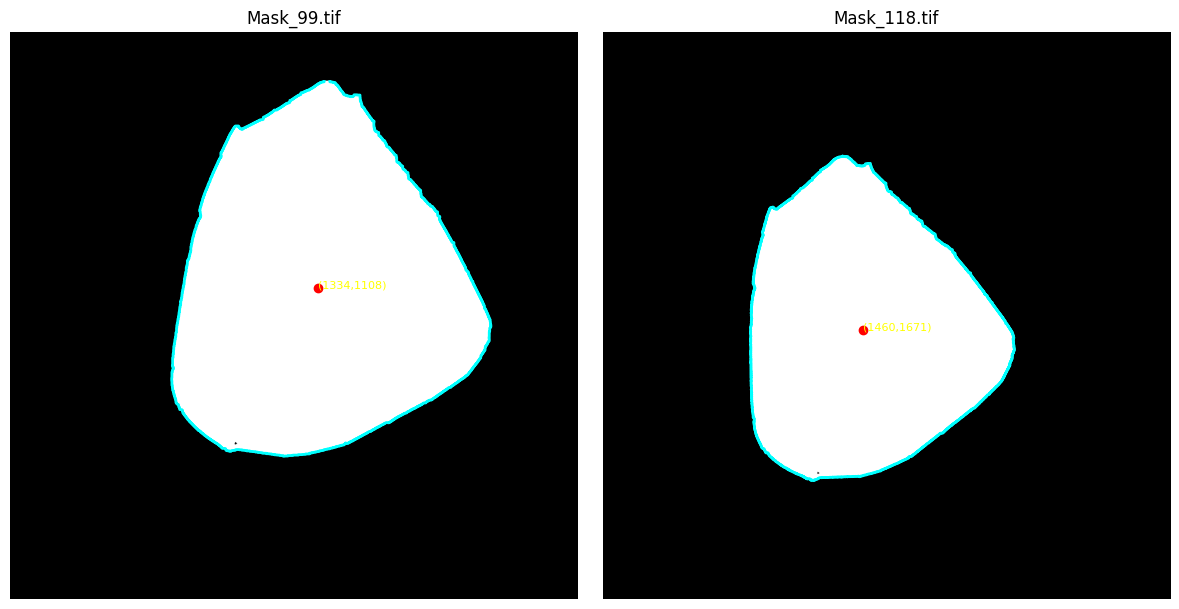

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_mask_contours_centroids(image_path, ax):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error reading image: {image_path}")
        return
    
    # Threshold the image to create a binary mask
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    # Find external contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Show the original image in the background
    ax.imshow(image, cmap='gray')
    
    # Loop over the contours
    for cnt in contours:
        # Draw the contour on the image
        cnt_pts = cnt.squeeze()  # Remove redundant dimensions for plotting
        if cnt_pts.ndim < 2:
            continue  # Skip if contour is not valid
        ax.plot(cnt_pts[:, 0], cnt_pts[:, 1], linewidth=2, color='cyan')
        
        # Compute the centroid using image moments
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            # Mark the centroid with a red dot
            ax.plot(cx, cy, 'ro')
            # Optionally annotate the centroid coordinates
            ax.text(cx, cy, f'({cx},{cy})', color='yellow', fontsize=8)
    
    # Remove axes and add a title using the file name
    ax.set_title(image_path.split('/')[-1])
    ax.axis('off')

# Paths to the mask images (adjust if needed)
mask1_path = 'Mask_99.tif'
mask2_path = 'Mask_118.tif'

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_mask_contours_centroids(mask1_path, axs[0])
plot_mask_contours_centroids(mask2_path, axs[1])

plt.tight_layout()
plt.show()


Automatic source points:
 [[ 935. 1813.]
 [ 919. 1805.]
 [1385.  215.]]
Automatic destination points:
 [[1145. 2503.]
 [1017. 2438.]
 [1344.  697.]]


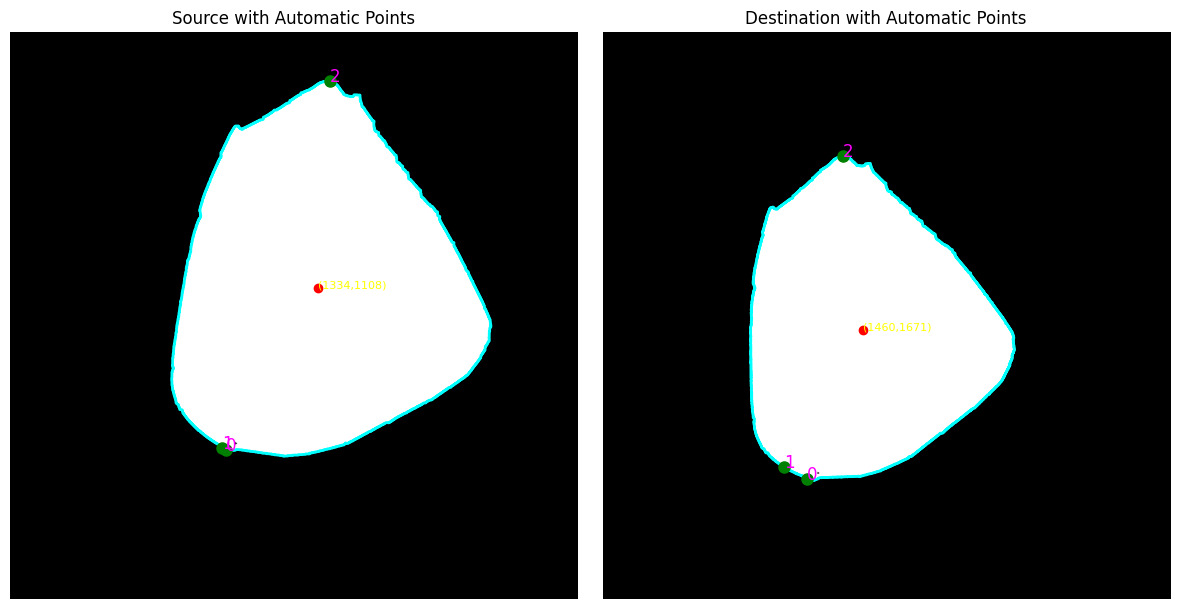

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_mask_with_points(image_path, points=None, title=None, ax=None):
    """
    Loads a mask image, plots its contours and centroids, and overlays given points.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error reading image: {image_path}")
        return None
    
    # Threshold to create a binary image
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    # Find external contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Use provided axis or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # Display the image
    ax.imshow(image, cmap='gray')
    
    # Plot each contour and its centroid
    for cnt in contours:
        cnt_pts = cnt.squeeze()
        if cnt_pts.ndim < 2:
            continue
        ax.plot(cnt_pts[:, 0], cnt_pts[:, 1], linewidth=2, color='cyan')
        # Compute centroid using moments
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            ax.plot(cx, cy, 'ro')
            ax.text(cx, cy, f'({cx},{cy})', color='yellow', fontsize=8)
    
    # Overlay the selected points (if provided)
    if points is not None:
        for i, (x, y) in enumerate(points):
            ax.plot(x, y, 'go', markersize=8)
            ax.text(x, y, f'{i}', color='magenta', fontsize=12)
    
    if title is None:
        title = image_path.split('/')[-1]
    ax.set_title(title)
    ax.axis('off')
    return image

def get_largest_contour(image):
    """
    Returns the largest contour found in the binary image.
    """
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    # Return the contour with maximum area
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def automatic_point_selection(contour, num_points=3):
    """
    Automatically selects `num_points` from the contour by dividing the
    360° around the centroid into equal sectors and picking the farthest point
    in each sector.
    """
    # Compute centroid of the contour
    M = cv2.moments(contour)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    centroid = np.array([cx, cy])
    
    # Flatten the contour points
    pts = contour.squeeze()
    if pts.ndim == 1:
        pts = pts[np.newaxis, :]
    
    # Compute angle (in degrees) and distance of each point from the centroid
    angles = np.arctan2(pts[:, 1] - cy, pts[:, 0] - cx)
    angles = np.degrees(angles) % 360  # ensure angles are between 0 and 360
    distances = np.linalg.norm(pts - centroid, axis=1)
    
    sector_angle = 360 / num_points
    selected_points = []
    for i in range(num_points):
        lower = i * sector_angle
        upper = (i + 1) * sector_angle
        # Get points within this sector
        mask = (angles >= lower) & (angles < upper)
        if np.any(mask):
            # Select the point with maximum distance from the centroid in this sector
            idx = np.argmax(distances[mask])
            sector_pts = pts[mask]
            selected_points.append(sector_pts[idx])
    return np.array(selected_points, dtype=np.float32)

# File paths to the mask images
mask1_path = 'Mask_99.tif'
mask2_path = 'Mask_118.tif'

# Process the source image
src_image = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
src_contour = get_largest_contour(src_image)
src_points = automatic_point_selection(src_contour, num_points=3)

# Process the destination image
dst_image = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)
dst_contour = get_largest_contour(dst_image)
dst_points = automatic_point_selection(dst_contour, num_points=3)

print("Automatic source points:\n", src_points)
print("Automatic destination points:\n", dst_points)

# Plot the source and destination masks side-by-side with the selected points
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_mask_with_points(mask1_path, points=src_points, title="Source with Automatic Points", ax=axs[0])
plot_mask_with_points(mask2_path, points=dst_points, title="Destination with Automatic Points", ax=axs[1])

plt.tight_layout()
plt.show()


Source Mask Properties:
Centroid (row, col): (1108.0772326463323, 1334.2113495989743)
Orientation (radians): -0.08516991866092422
Major axis length: 1568.0164204334787

Destination Mask Properties:
Centroid (row, col): (1671.532078832354, 1460.2628128234076)
Orientation (radians): 0.08941026449089369
Major axis length: 1719.7080017621665


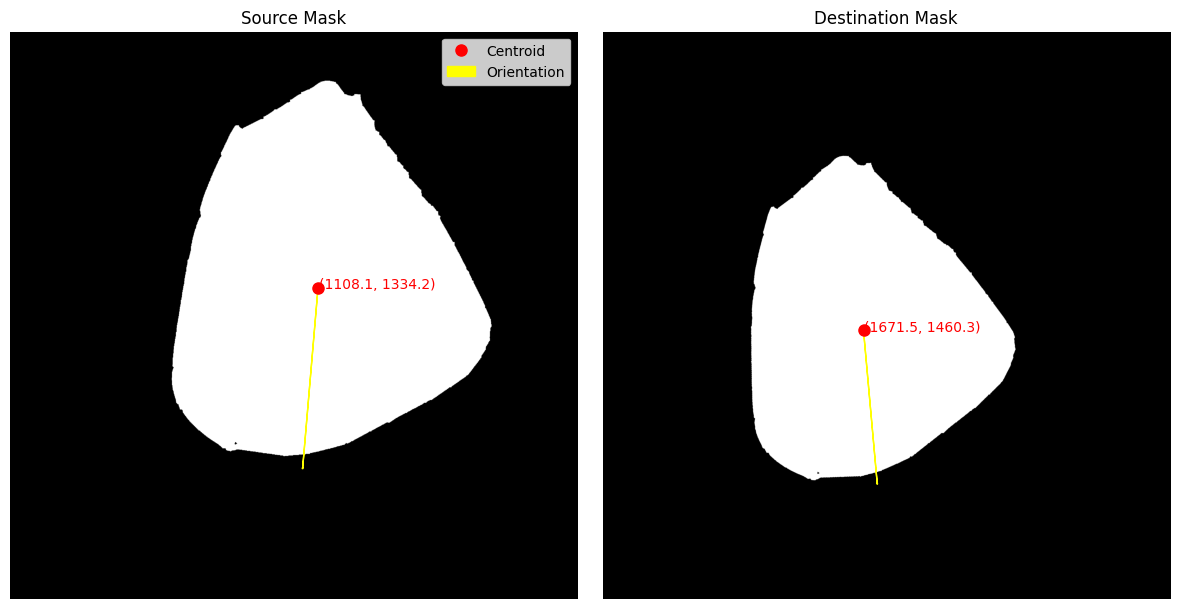

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, img_as_float

# Load masks as grayscale images and convert to float
mask_src = img_as_float(io.imread('Mask_99.tif', as_gray=True))
mask_dst = img_as_float(io.imread('Mask_118.tif', as_gray=True))

# Binarize images with a threshold of 0.5 (adjust if needed)
mask_src_bin = mask_src > 0.5
mask_dst_bin = mask_dst > 0.5

# Compute region properties for the largest connected region in each mask
props_src = measure.regionprops(mask_src_bin.astype(int))
props_dst = measure.regionprops(mask_dst_bin.astype(int))

# Assume the largest region represents the object of interest
region_src = props_src[0]
region_dst = props_dst[0]

# Get properties: centroid, orientation (in radians), and major axis length
centroid_src = region_src.centroid  # (row, col)
orientation_src = region_src.orientation
major_axis_src = region_src.major_axis_length

centroid_dst = region_dst.centroid
orientation_dst = region_dst.orientation
major_axis_dst = region_dst.major_axis_length

print("Source Mask Properties:")
print("Centroid (row, col):", centroid_src)
print("Orientation (radians):", orientation_src)
print("Major axis length:", major_axis_src)

print("\nDestination Mask Properties:")
print("Centroid (row, col):", centroid_dst)
print("Orientation (radians):", orientation_dst)
print("Major axis length:", major_axis_dst)

# Plot each mask with the computed properties
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for ax, mask, centroid, orientation, major_axis, title in zip(
    axs, [mask_src_bin, mask_dst_bin],
    [centroid_src, centroid_dst],
    [orientation_src, orientation_dst],
    [major_axis_src, major_axis_dst],
    ["Source Mask", "Destination Mask"]):
    
    # Display the binary mask
    ax.imshow(mask, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    
    # Mark the centroid (note: centroid is in (row, col) which maps to (y, x))
    ax.plot(centroid[1], centroid[0], 'ro', markersize=8, label="Centroid")
    ax.text(centroid[1] + 5, centroid[0] + 5,
            f'({centroid[0]:.1f}, {centroid[1]:.1f})', color='red', fontsize=10)
    
    # Draw an arrow indicating orientation.
    # Use half of the major axis length for the arrow's length.
    arrow_length = major_axis / 2
    # In image coordinates: x component = arrow_length * sin(orientation)
    # y component = arrow_length * cos(orientation)
    dx = arrow_length * np.sin(orientation)
    dy = arrow_length * np.cos(orientation)
    # Draw arrow (x corresponds to column, y to row)
    ax.arrow(centroid[1], centroid[0], dx, dy, head_width=5, head_length=5, fc='yellow', ec='yellow', label="Orientation")

# Optionally, add a legend to one subplot
axs[0].legend(loc='upper right')

plt.tight_layout()
plt.show()


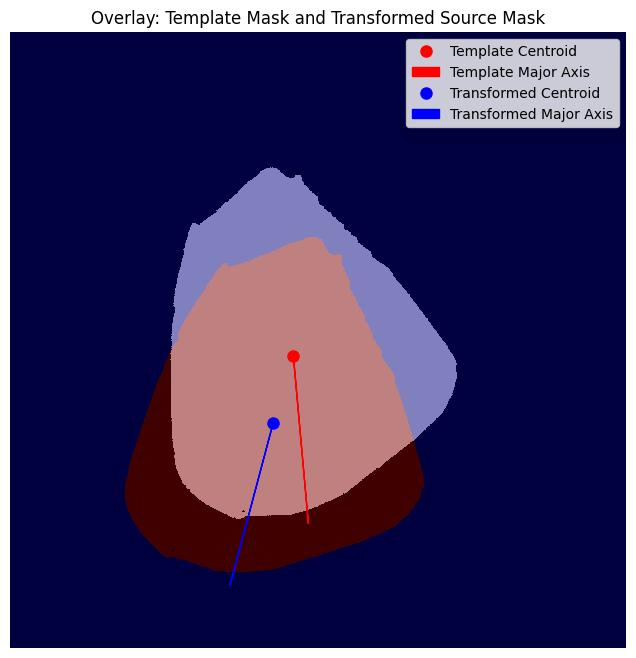

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, transform, img_as_float

# --- Load and binarize the masks ---
mask_src = img_as_float(io.imread('Mask_99.tif', as_gray=True))
mask_dst = img_as_float(io.imread('Mask_118.tif', as_gray=True))

# Binarize the images using a threshold (adjust threshold if needed)
mask_src_bin = mask_src > 0.5
mask_dst_bin = mask_dst > 0.5

# --- Compute region properties for both masks ---
props_src = measure.regionprops(mask_src_bin.astype(int))
props_dst = measure.regionprops(mask_dst_bin.astype(int))

# Assume the largest region represents the object of interest
region_src = props_src[0]
region_dst = props_dst[0]

# Get properties: centroid (row, col), orientation (radians), and major axis length (proxy for scale)
centroid_src = np.array(region_src.centroid)
centroid_dst = np.array(region_dst.centroid)
orientation_src = region_src.orientation
orientation_dst = region_dst.orientation
major_axis_src = region_src.major_axis_length
major_axis_dst = region_dst.major_axis_length

# --- Compute transformation parameters based on region properties ---
# Scaling factor: ratio of major axis lengths
scale_factor = major_axis_dst / major_axis_src
# Rotation: difference in orientation (in radians)
rotation_angle = orientation_dst - orientation_src
# Translation: difference between centroids (note: scikit-image expects (col, row))
translation = (centroid_dst[::-1] - centroid_src[::-1])

# Create the similarity transform
tform = transform.SimilarityTransform(scale=scale_factor, 
                                      rotation=rotation_angle, 
                                      translation=translation)

# --- Warp the source mask ---
warped_src = transform.warp(mask_src_bin.astype(float), inverse_map=tform.inverse, output_shape=mask_dst.shape)
# Since interpolation produces gray values, threshold to get a binary image again.
warped_src_bin = warped_src > 0.5

# --- Compute region properties on the warped source mask ---
props_warped = measure.regionprops(warped_src_bin.astype(int))
if len(props_warped) == 0:
    raise ValueError("No region found in the warped image.")
region_warped = props_warped[0]
centroid_warped = region_warped.centroid
orientation_warped = region_warped.orientation
major_axis_warped = region_warped.major_axis_length

# --- Overlay the template and transformed source in one plot ---
plt.figure(figsize=(8, 8))
# Display the template mask in grayscale
plt.imshow(mask_dst_bin, cmap='gray', interpolation='none')
# Overlay the warped source mask with a transparency (alpha)
plt.imshow(warped_src_bin, cmap='jet', alpha=0.5, interpolation='none')

# --- Mark region properties for the template mask (destination) ---
# Mark the centroid (x=col, y=row)
plt.plot(centroid_dst[1], centroid_dst[0], 'ro', markersize=8, label='Template Centroid')
# Draw an arrow for the major axis (half length used)
arrow_length_dst = major_axis_dst / 2
dx_dst = arrow_length_dst * np.sin(orientation_dst)
dy_dst = arrow_length_dst * np.cos(orientation_dst)
plt.arrow(centroid_dst[1], centroid_dst[0], dx_dst, dy_dst,
          head_width=5, head_length=5, fc='red', ec='red', label='Template Major Axis')

# --- Mark region properties for the transformed (warped) source mask ---
plt.plot(centroid_warped[1], centroid_warped[0], 'bo', markersize=8, label='Transformed Centroid')
arrow_length_warped = major_axis_warped / 2
dx_warped = arrow_length_warped * np.sin(orientation_warped)
dy_warped = arrow_length_warped * np.cos(orientation_warped)
plt.arrow(centroid_warped[1], centroid_warped[0], dx_warped, dy_warped,
          head_width=5, head_length=5, fc='blue', ec='blue', label='Transformed Major Axis')

plt.title("Overlay: Template Mask and Transformed Source Mask")
plt.axis('off')
plt.legend(loc='upper right')
plt.show()


Source ellipse parameters (regionprops):
  Centroid (row, col)   = (1414.40, 1301.46)
  Orientation (vertical-based) = -0.09 rad
  => Orientation (horizontal-based) = 1.66 rad
  Major axis length     = 1969.90
  Minor axis length     = 1643.86

Destination ellipse parameters (regionprops):
  Centroid (row, col)   = (1671.53, 1460.26)
  Orientation (vertical-based) = 0.09 rad
  => Orientation (horizontal-based) = 1.48 rad
  Major axis length     = 1719.71
  Minor axis length     = 1435.04


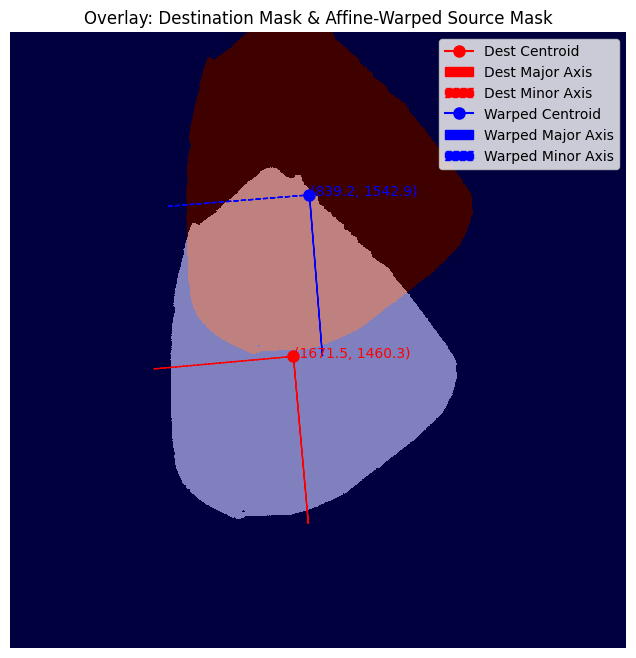

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, transform, img_as_float

def ellipse_to_ellipse_transform(cx_s, cy_s, orient_s, major_s, minor_s,
                                 cx_t, cy_t, orient_t, major_t, minor_t):
    """
    Build an AffineTransform that maps the ellipse defined by
    (cx_s, cy_s, orient_s, major_s, minor_s) to the ellipse
    (cx_t, cy_t, orient_t, major_t, minor_t).

    'orient_s' and 'orient_t' are angles measured from the horizontal axis
    (i.e., 0 means major axis is horizontal).

    Steps:
      1) Translate source centroid to origin
      2) Rotate by -orient_s (align major axis with x-axis)
      3) Scale x by (major_t/major_s) and y by (minor_t/minor_s)
      4) Rotate by orient_t
      5) Translate to target centroid
    """
    # 1) Translate source centroid to origin
    T1 = transform.AffineTransform(translation=(-cx_s, -cy_s))
    
    # 2) Rotate by -orient_s to align the source's major axis with x-axis
    R1 = transform.AffineTransform(rotation=-orient_s)
    
    # 3) Scale X and Y by the ratios of major and minor axes
    sx = major_t / major_s
    sy = minor_t / minor_s
    S = transform.AffineTransform(scale=(sx, sy))
    
    # 4) Rotate by orient_t to match the target's major axis orientation
    R2 = transform.AffineTransform(rotation=orient_t)
    
    # 5) Translate to the target centroid
    T2 = transform.AffineTransform(translation=(cx_t, cy_t))

    # Combine all transforms in the correct order
    return T2 + R2 + S + R1 + T1

def draw_axes(ax, centroid, orientation, major_len, minor_len, color='red', label_prefix=''):
    """
    Draws the centroid, major axis, and minor axis on the given axes 'ax'.
    
    - 'orientation' is the angle (in radians) measured from the HORIZONTAL axis
      (i.e., 0 means the major axis is purely horizontal).
    - 'major_len' and 'minor_len' are the lengths of the major and minor axes.
    - 'centroid' is (row, col), but we swap to (x, y) when plotting.

    The major axis is drawn as a solid arrow, and the minor axis as a dashed arrow.
    """
    cy, cx = centroid  # regionprops gives (row, col)
    
    # Plot the centroid: note we plot at (x=cx, y=cy)
    ax.plot(cx, cy, marker='o', color=color, markersize=8, label=f'{label_prefix} Centroid')
    ax.text(cx + 5, cy + 5, f'({cy:.1f}, {cx:.1f})', color=color, fontsize=10)
    
    # Major axis: half the length from the centroid
    half_major = major_len / 2.0
    dx_major = half_major * np.cos(orientation)
    dy_major = half_major * np.sin(orientation)
    ax.arrow(cx, cy, dx_major, dy_major,
             head_width=5, head_length=5, fc=color, ec=color,
             label=f'{label_prefix} Major Axis')
    
    # Minor axis: perpendicular to the major axis => orientation + pi/2
    half_minor = minor_len / 2.0
    orientation_minor = orientation + np.pi / 2
    dx_minor = half_minor * np.cos(orientation_minor)
    dy_minor = half_minor * np.sin(orientation_minor)
    ax.arrow(cx, cy, dx_minor, dy_minor,
             head_width=5, head_length=5, fc=color, ec=color, linestyle='--',
             label=f'{label_prefix} Minor Axis')

# --------------------------------------------------------------------------
# 1. Load and binarize the source and destination masks
# --------------------------------------------------------------------------
src = img_as_float(io.imread('Mask_82.tif', as_gray=True))
dst = img_as_float(io.imread('Mask_118.tif', as_gray=True))

mask_src = src > 0.5
mask_dst = dst > 0.5

# --------------------------------------------------------------------------
# 2. Compute region properties (centroid, orientation, major/minor axes)
# --------------------------------------------------------------------------
props_src = measure.regionprops(mask_src.astype(int))
props_dst = measure.regionprops(mask_dst.astype(int))

region_src = props_src[0]  # assume largest region
region_dst = props_dst[0]

# regionprops centroid is (row, col)
cy_s, cx_s = region_src.centroid
cy_t, cx_t = region_dst.centroid

# regionprops.orientation is measured from the VERTICAL axis:
#  -> orientation=0 => major axis is vertical
#  -> We want orientation from the HORIZONTAL axis
#  -> Convert: orient_h = pi/2 - orient_regionprops
orient_s_region = region_src.orientation
orient_t_region = region_dst.orientation
orient_s = np.pi/2 - orient_s_region
orient_t = np.pi/2 - orient_t_region

# Major and minor axis lengths
major_s = region_src.major_axis_length
minor_s = region_src.minor_axis_length
major_t = region_dst.major_axis_length
minor_t = region_dst.minor_axis_length

print("Source ellipse parameters (regionprops):")
print(f"  Centroid (row, col)   = ({cy_s:.2f}, {cx_s:.2f})")
print(f"  Orientation (vertical-based) = {orient_s_region:.2f} rad")
print(f"  => Orientation (horizontal-based) = {orient_s:.2f} rad")
print(f"  Major axis length     = {major_s:.2f}")
print(f"  Minor axis length     = {minor_s:.2f}")

print("\nDestination ellipse parameters (regionprops):")
print(f"  Centroid (row, col)   = ({cy_t:.2f}, {cx_t:.2f})")
print(f"  Orientation (vertical-based) = {orient_t_region:.2f} rad")
print(f"  => Orientation (horizontal-based) = {orient_t:.2f} rad")
print(f"  Major axis length     = {major_t:.2f}")
print(f"  Minor axis length     = {minor_t:.2f}")

# --------------------------------------------------------------------------
# 3. Construct an affine transform that maps the source ellipse to the destination ellipse
#    using the horizontal-based orientation angles.
# --------------------------------------------------------------------------
affine_tform = ellipse_to_ellipse_transform(
    cx_s, cy_s, orient_s, major_s, minor_s,
    cx_t, cy_t, orient_t, major_t, minor_t
)

# --------------------------------------------------------------------------
# 4. Warp the source mask
# --------------------------------------------------------------------------
warped_src = transform.warp(mask_src.astype(float),
                            inverse_map=affine_tform.inverse,
                            output_shape=mask_dst.shape)
warped_src_bin = warped_src > 0.5  # Re-binarize if needed

# Compute region properties on the warped source
props_warped = measure.regionprops(warped_src_bin.astype(int))
region_warped = props_warped[0]
cy_w, cx_w = region_warped.centroid

# regionprops orientation again is from the vertical axis,
# so we convert to horizontal-based for drawing
orient_w_region = region_warped.orientation
orient_w = np.pi/2 - orient_w_region
major_w = region_warped.major_axis_length
minor_w = region_warped.minor_axis_length

# --------------------------------------------------------------------------
# 5. Overlay the destination and warped source in one plot, marking centroids & axes
# --------------------------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(mask_dst, cmap='gray', interpolation='none')
plt.imshow(warped_src_bin, cmap='jet', alpha=0.5, interpolation='none')
plt.title("Overlay: Destination Mask & Affine-Warped Source Mask")
plt.axis('off')

# Draw the destination's centroid and axes in RED
draw_axes(plt.gca(), (cy_t, cx_t), orient_t, major_t, minor_t,
          color='red', label_prefix='Dest')

# Draw the warped source's centroid and axes in BLUE
draw_axes(plt.gca(), (cy_w, cx_w), orient_w, major_w, minor_w,
          color='blue', label_prefix='Warped')

plt.legend(loc='upper right')
plt.show()


Source ellipse parameters (regionprops):
  Centroid (row, col): (1414.40, 1301.46)
  Orientation (vertical-based): -0.09 rad
  => Orientation (horizontal-based): 1.66 rad
  Major axis length: 1969.90
  Minor axis length: 1643.86

Destination ellipse parameters (regionprops):
  Centroid (row, col): (1671.53, 1460.26)
  Orientation (vertical-based): 0.09 rad
  => Orientation (horizontal-based): 1.48 rad
  Major axis length: 1719.71
  Minor axis length: 1435.04

Pure shift required: Δx = -82.67, Δy = 832.34

After pure shift adjustment:
  Adjusted warped centroid: (1671.39, 1460.12)
  Destination centroid:     (1671.53, 1460.26)


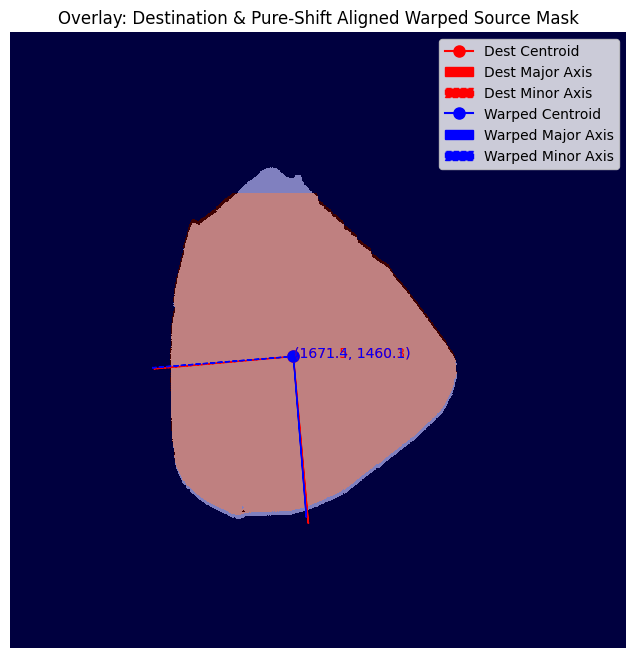

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, transform, img_as_float

def ellipse_to_ellipse_transform(cx_s, cy_s, orient_s, major_s, minor_s,
                                 cx_t, cy_t, orient_t, major_t, minor_t):
    """
    Build an AffineTransform that maps the ellipse defined by
    (cx_s, cy_s, orient_s, major_s, minor_s) to the ellipse
    (cx_t, cy_t, orient_t, major_t, minor_t).

    'orient_s' and 'orient_t' are angles measured from the horizontal axis.
    Steps:
      1) Translate source centroid to origin.
      2) Rotate by -orient_s (align major axis with x-axis).
      3) Scale x by (major_t/major_s) and y by (minor_t/minor_s).
      4) Rotate by orient_t.
      5) Translate to target centroid.
    """
    T1 = transform.AffineTransform(translation=(-cx_s, -cy_s))
    R1 = transform.AffineTransform(rotation=-orient_s)
    sx = major_t / major_s
    sy = minor_t / minor_s
    S = transform.AffineTransform(scale=(sx, sy))
    R2 = transform.AffineTransform(rotation=orient_t)
    T2 = transform.AffineTransform(translation=(cx_t, cy_t))
    return T2 + R2 + S + R1 + T1

def draw_axes(ax, centroid, orientation, major_len, minor_len, color='red', label_prefix=''):
    """
    Draws the centroid, major axis, and minor axis on the given axes 'ax'.
    'orientation' is measured from the HORIZONTAL axis.
    'centroid' is given as (row, col), but we swap to (x, y) for plotting.
    """
    cy, cx = centroid  # regionprops returns (row, col)
    # Plot centroid at (x=cx, y=cy)
    ax.plot(cx, cy, marker='o', color=color, markersize=8, label=f'{label_prefix} Centroid')
    ax.text(cx + 5, cy + 5, f'({cy:.1f}, {cx:.1f})', color=color, fontsize=10)
    
    half_major = major_len / 2.0
    dx_major = half_major * np.cos(orientation)
    dy_major = half_major * np.sin(orientation)
    ax.arrow(cx, cy, dx_major, dy_major,
             head_width=5, head_length=5, fc=color, ec=color,
             label=f'{label_prefix} Major Axis')
    
    half_minor = minor_len / 2.0
    orientation_minor = orientation + np.pi / 2
    dx_minor = half_minor * np.cos(orientation_minor)
    dy_minor = half_minor * np.sin(orientation_minor)
    ax.arrow(cx, cy, dx_minor, dy_minor,
             head_width=5, head_length=5, fc=color, ec=color, linestyle='--',
             label=f'{label_prefix} Minor Axis')

# -------------------------------
# 1. Load and binarize the masks
# -------------------------------
src = img_as_float(io.imread('Mask_82.tif', as_gray=True))
dst = img_as_float(io.imread('Mask_118.tif', as_gray=True))
mask_src = src > 0.5
mask_dst = dst > 0.5

# ----------------------------------------------------
# 2. Compute region properties for source and destination
# ----------------------------------------------------
props_src = measure.regionprops(mask_src.astype(int))
props_dst = measure.regionprops(mask_dst.astype(int))
region_src = props_src[0]  # assume largest region
region_dst = props_dst[0]

# Centroids are given as (row, col)
cy_s, cx_s = region_src.centroid
cy_t, cx_t = region_dst.centroid

# regionprops.orientation is measured from the vertical axis.
# To convert to an angle from the horizontal axis:
#   orient_horizontal = pi/2 - orient_regionprops
orient_s_region = region_src.orientation
orient_t_region = region_dst.orientation
orient_s = np.pi/2 - orient_s_region
orient_t = np.pi/2 - orient_t_region

# Major and minor axis lengths
major_s = region_src.major_axis_length
minor_s = region_src.minor_axis_length
major_t = region_dst.major_axis_length
minor_t = region_dst.minor_axis_length

print("Source ellipse parameters (regionprops):")
print(f"  Centroid (row, col): ({cy_s:.2f}, {cx_s:.2f})")
print(f"  Orientation (vertical-based): {orient_s_region:.2f} rad")
print(f"  => Orientation (horizontal-based): {orient_s:.2f} rad")
print(f"  Major axis length: {major_s:.2f}")
print(f"  Minor axis length: {minor_s:.2f}")

print("\nDestination ellipse parameters (regionprops):")
print(f"  Centroid (row, col): ({cy_t:.2f}, {cx_t:.2f})")
print(f"  Orientation (vertical-based): {orient_t_region:.2f} rad")
print(f"  => Orientation (horizontal-based): {orient_t:.2f} rad")
print(f"  Major axis length: {major_t:.2f}")
print(f"  Minor axis length: {minor_t:.2f}")

# ----------------------------------------------------
# 3. Construct the initial affine transform based on ellipses
# ----------------------------------------------------
affine_tform = ellipse_to_ellipse_transform(
    cx_s, cy_s, orient_s, major_s, minor_s,
    cx_t, cy_t, orient_t, major_t, minor_t
)

# ----------------------------------------------------
# 4. Warp the source mask using the initial transform
# ----------------------------------------------------
warped_src = transform.warp(mask_src.astype(float),
                            inverse_map=affine_tform.inverse,
                            output_shape=mask_dst.shape)
warped_src_bin = warped_src > 0.5  # re-binarize if necessary

# Compute region properties of the initially warped source
props_warped = measure.regionprops(warped_src_bin.astype(int))
region_warped = props_warped[0]
cy_w, cx_w = region_warped.centroid

# ----------------------------------------------------
# 5. Compute extra translation (pure shift) to align centroids exactly
# ----------------------------------------------------
# Calculate differences (centroids in (row, col) = (y, x))
delta_x = cx_t - cx_w
delta_y = cy_t - cy_w

print(f"\nPure shift required: Δx = {delta_x:.2f}, Δy = {delta_y:.2f}")

# Create a pure translation transform (only shifting the already warped mask)
T_adjust = transform.AffineTransform(translation=(delta_x, delta_y))
# Apply the pure translation to the already affine-warped mask.
warped_src_adjusted = transform.warp(warped_src_bin.astype(float),
                                     inverse_map=T_adjust.inverse,
                                     output_shape=mask_dst.shape)
warped_src_adjusted_bin = warped_src_adjusted > 0.5

# Recompute properties on the adjusted warp
props_adjusted = measure.regionprops(warped_src_adjusted_bin.astype(int))
region_adjusted = props_adjusted[0]
cy_adj, cx_adj = region_adjusted.centroid
orient_adj_region = region_adjusted.orientation
orient_adj = np.pi/2 - orient_adj_region
major_adj = region_adjusted.major_axis_length
minor_adj = region_adjusted.minor_axis_length

print("\nAfter pure shift adjustment:")
print(f"  Adjusted warped centroid: ({cy_adj:.2f}, {cx_adj:.2f})")
print(f"  Destination centroid:     ({cy_t:.2f}, {cx_t:.2f})")

# ----------------------------------------------------
# 6. Overlay the destination mask and adjusted warped source mask, marking centroids & axes
# ----------------------------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(mask_dst, cmap='gray', interpolation='none')
plt.imshow(warped_src_adjusted_bin, cmap='jet', alpha=0.5, interpolation='none')
plt.title("Overlay: Destination & Pure-Shift Aligned Warped Source Mask")
plt.axis('off')

# Draw destination's centroid and axes in RED
draw_axes(plt.gca(), (cy_t, cx_t), orient_t, major_t, minor_t,
          color='red', label_prefix='Dest')

# Draw adjusted warped source's centroid and axes in BLUE
draw_axes(plt.gca(), (cy_adj, cx_adj), orient_adj, major_adj, minor_adj,
          color='blue', label_prefix='Warped')

plt.legend(loc='upper right')
plt.show()


Source ellipse parameters (regionprops):
  Centroid (row, col): (1414.40, 1301.46)
  Orientation (vertical-based): -0.09 rad
  => Orientation (horizontal-based): 1.66 rad
  Major axis length: 1969.90
  Minor axis length: 1643.86

Destination ellipse parameters (regionprops):
  Centroid (row, col): (1671.53, 1460.26)
  Adjusted Centroid (large canvas): (2465.03, 2253.76)
  Orientation (vertical-based): 0.09 rad
  => Orientation (horizontal-based): 1.48 rad
  Major axis length: 1719.71
  Minor axis length: 1435.04

Pure shift required on large canvas: Δx = -89.57, Δy = 1083.46

After pure shift adjustment (large canvas):
  Adjusted warped centroid: (2464.82, 2253.52)
  Destination (large canvas) centroid: (2465.03, 2253.76)

After cropping to target size:
  Final warped centroid: (1671.82, 1460.52)


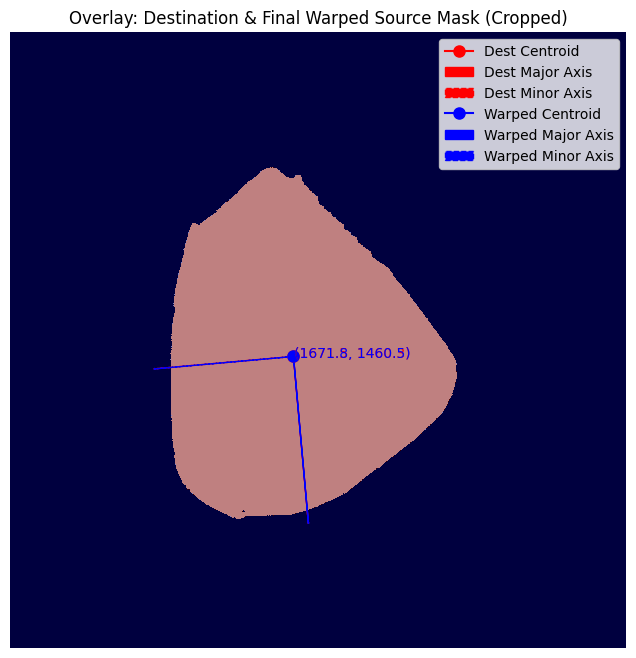

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, transform, img_as_float

def ellipse_to_ellipse_transform(cx_s, cy_s, orient_s, major_s, minor_s,
                                 cx_t, cy_t, orient_t, major_t, minor_t):
    """
    Build an AffineTransform that maps the ellipse defined by
    (cx_s, cy_s, orient_s, major_s, minor_s) to the ellipse
    (cx_t, cy_t, orient_t, major_t, minor_t).

    'orient_s' and 'orient_t' are angles measured from the horizontal axis.
    Steps:
      1) Translate source centroid to origin.
      2) Rotate by -orient_s (align major axis with x-axis).
      3) Scale x by (major_t/major_s) and y by (minor_t/minor_s).
      4) Rotate by orient_t.
      5) Translate to target centroid.
    """
    T1 = transform.AffineTransform(translation=(-cx_s, -cy_s))
    R1 = transform.AffineTransform(rotation=-orient_s)
    sx = major_t / major_s
    sy = minor_t / minor_s
    S = transform.AffineTransform(scale=(sx, sy))
    R2 = transform.AffineTransform(rotation=orient_t)
    T2 = transform.AffineTransform(translation=(cx_t, cy_t))
    return T2 + R2 + S + R1 + T1

def draw_axes(ax, centroid, orientation, major_len, minor_len, color='red', label_prefix=''):
    """
    Draws the centroid, major axis, and minor axis on the given axes 'ax'.
    'orientation' is measured from the HORIZONTAL axis.
    'centroid' is given as (row, col), but we swap to (x, y) for plotting.
    """
    cy, cx = centroid  # regionprops returns (row, col)
    ax.plot(cx, cy, marker='o', color=color, markersize=8, label=f'{label_prefix} Centroid')
    ax.text(cx + 5, cy + 5, f'({cy:.1f}, {cx:.1f})', color=color, fontsize=10)
    
    half_major = major_len / 2.0
    dx_major = half_major * np.cos(orientation)
    dy_major = half_major * np.sin(orientation)
    ax.arrow(cx, cy, dx_major, dy_major,
             head_width=5, head_length=5, fc=color, ec=color,
             label=f'{label_prefix} Major Axis')
    
    half_minor = minor_len / 2.0
    orientation_minor = orientation + np.pi / 2
    dx_minor = half_minor * np.cos(orientation_minor)
    dy_minor = half_minor * np.sin(orientation_minor)
    ax.arrow(cx, cy, dx_minor, dy_minor,
             head_width=5, head_length=5, fc=color, ec=color, linestyle='--',
             label=f'{label_prefix} Minor Axis')

# -------------------------------
# 1. Load and binarize the masks
# -------------------------------
src = img_as_float(io.imread('Mask_99.tif', as_gray=True))
dst = img_as_float(io.imread('Mask_118.tif', as_gray=True))
mask_src = src > 0.5
mask_dst = dst > 0.5

# Get target dimensions
H, W = mask_dst.shape

# We'll create a larger canvas (1.5 times bigger)
newH, newW = int(1.5 * H), int(1.5 * W)
# Compute offsets so that the target is centered on the large canvas
offset_y, offset_x = (newH - H) / 2.0, (newW - W) / 2.0

# ----------------------------------------------------
# 2. Compute region properties for source and destination
# ----------------------------------------------------
props_src = measure.regionprops(mask_src.astype(int))
props_dst = measure.regionprops(mask_dst.astype(int))
region_src = props_src[0]  # assume largest region
region_dst = props_dst[0]

# Centroids are (row, col)
cy_s, cx_s = region_src.centroid
cy_t, cx_t = region_dst.centroid

# Adjust destination centroid for the larger canvas:
cy_t_large = cy_t + offset_y
cx_t_large = cx_t + offset_x

# regionprops.orientation is from the vertical axis.
# Convert to an angle measured from the horizontal axis:
orient_s_region = region_src.orientation
orient_t_region = region_dst.orientation
orient_s = np.pi/2 - orient_s_region
orient_t = np.pi/2 - orient_t_region

# Major and minor axis lengths
major_s = region_src.major_axis_length
minor_s = region_src.minor_axis_length
major_t = region_dst.major_axis_length
minor_t = region_dst.minor_axis_length

print("Source ellipse parameters (regionprops):")
print(f"  Centroid (row, col): ({cy_s:.2f}, {cx_s:.2f})")
print(f"  Orientation (vertical-based): {orient_s_region:.2f} rad")
print(f"  => Orientation (horizontal-based): {orient_s:.2f} rad")
print(f"  Major axis length: {major_s:.2f}")
print(f"  Minor axis length: {minor_s:.2f}")

print("\nDestination ellipse parameters (regionprops):")
print(f"  Centroid (row, col): ({cy_t:.2f}, {cx_t:.2f})")
print(f"  Adjusted Centroid (large canvas): ({cy_t_large:.2f}, {cx_t_large:.2f})")
print(f"  Orientation (vertical-based): {orient_t_region:.2f} rad")
print(f"  => Orientation (horizontal-based): {orient_t:.2f} rad")
print(f"  Major axis length: {major_t:.2f}")
print(f"  Minor axis length: {minor_t:.2f}")

# ----------------------------------------------------
# 3. Construct the initial affine transform based on ellipses
# Use the adjusted destination centroid for the large canvas.
# ----------------------------------------------------
affine_tform = ellipse_to_ellipse_transform(
    cx_s, cy_s, orient_s, major_s, minor_s,
    cx_t_large, cy_t_large, orient_t, major_t, minor_t
)

# ----------------------------------------------------
# 4. Warp the source mask using the initial transform on the large canvas
# ----------------------------------------------------
warped_src = transform.warp(mask_src.astype(float),
                            inverse_map=affine_tform.inverse,
                            output_shape=(newH, newW))
warped_src_bin = warped_src > 0.5  # re-binarize if necessary

# Compute region properties of the warped source on the large canvas
props_warped = measure.regionprops(warped_src_bin.astype(int))
region_warped = props_warped[0]
cy_w, cx_w = region_warped.centroid

# ----------------------------------------------------
# 5. Compute extra translation (pure shift) on the large canvas
# ----------------------------------------------------
delta_x = cx_t_large - cx_w
delta_y = cy_t_large - cy_w

print(f"\nPure shift required on large canvas: Δx = {delta_x:.2f}, Δy = {delta_y:.2f}")

T_adjust = transform.AffineTransform(translation=(delta_x, delta_y))

# Apply the pure translation to the warped source (still on the large canvas)
warped_src_adjusted = transform.warp(warped_src_bin.astype(float),
                                     inverse_map=T_adjust.inverse,
                                     output_shape=(newH, newW))
warped_src_adjusted_bin = warped_src_adjusted > 0.5

# Recompute properties on the adjusted warp on the large canvas
props_adjusted = measure.regionprops(warped_src_adjusted_bin.astype(int))
region_adjusted = props_adjusted[0]
cy_adj, cx_adj = region_adjusted.centroid
orient_adj_region = region_adjusted.orientation
orient_adj = np.pi/2 - orient_adj_region
major_adj = region_adjusted.major_axis_length
minor_adj = region_adjusted.minor_axis_length

print("\nAfter pure shift adjustment (large canvas):")
print(f"  Adjusted warped centroid: ({cy_adj:.2f}, {cx_adj:.2f})")
print(f"  Destination (large canvas) centroid: ({cy_t_large:.2f}, {cx_t_large:.2f})")

# ----------------------------------------------------
# 6. Crop the final result to the original destination size
# ----------------------------------------------------
# Determine integer offsets for cropping
offset_y_int = int(offset_y)
offset_x_int = int(offset_x)
final_warped = warped_src_adjusted_bin[offset_y_int:offset_y_int+H, offset_x_int:offset_x_int+W]

# Recompute properties on the final cropped warped mask (optional)
props_final = measure.regionprops(final_warped.astype(int))
if props_final:
    region_final = props_final[0]
    cy_final, cx_final = region_final.centroid
    orient_final_region = region_final.orientation
    orient_final = np.pi/2 - orient_final_region
    major_final = region_final.major_axis_length
    minor_final = region_final.minor_axis_length
    print("\nAfter cropping to target size:")
    print(f"  Final warped centroid: ({cy_final:.2f}, {cx_final:.2f})")
else:
    print("\nWarning: No region detected in the final cropped image.")

# ----------------------------------------------------
# 7. Overlay the destination mask and final warped source mask, marking centroids & axes
# ----------------------------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(mask_dst, cmap='gray', interpolation='none')
plt.imshow(final_warped, cmap='jet', alpha=0.5, interpolation='none')
plt.title("Overlay: Destination & Final Warped Source Mask (Cropped)")
plt.axis('off')

# Draw destination's centroid and axes in RED
draw_axes(plt.gca(), (cy_t, cx_t), orient_t, major_t, minor_t,
          color='red', label_prefix='Dest')

# Draw final warped source's centroid and axes in BLUE (if region exists)
if props_final:
    draw_axes(plt.gca(), (cy_final, cx_final), orient_final, major_final, minor_final,
              color='blue', label_prefix='Warped')
    
plt.legend(loc='upper right')
plt.show()
